In [4]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
#from catalyst import utils

#sns.set(style="darkgrid", font_scale=1.4)


## Logistic Regression

Let's take a look at what happens in logistic regression. At the input we have a matrix object-attribute X and a column-vector $y$ - labels from $\{0, 1\}$ for each object. We want to find a matrix of weights $W$ and a bias $b$ that our model $XW + b$ will somehow predict the class of the object. As you can see in the output, our model can produce a number in the range from $(-\infty;\infty)$. This output is commonly referred to as "logits". We need to translate it to the interval from $[0; 1]$ in order for it to give us the probability of the object belonging to the first class, it is also better for this function to be monotonic, quickly calculated, have a derivative and on $-\infty$ have the value $0$, on $+\infty$ - $1$. This class of functions is called sigmoid. Most often we take as a sigmoid
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

I will write a PyTorch module that implements $logits = XW + b$, where $W$ and $b$ are [parameters](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html) (`nn.Parameter`) of the model. In other words, here I implement the [module `nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) with our own hands. I will initialize weights with normal distribution (`torch.randn`).

In [5]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

### Make Moons dataset

Let's initialize `make_moons` dataset:

In [6]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.07)

In [12]:
X.shape

(10000, 2)

In [13]:
y.shape

(10000,)

We can look at it in this way:

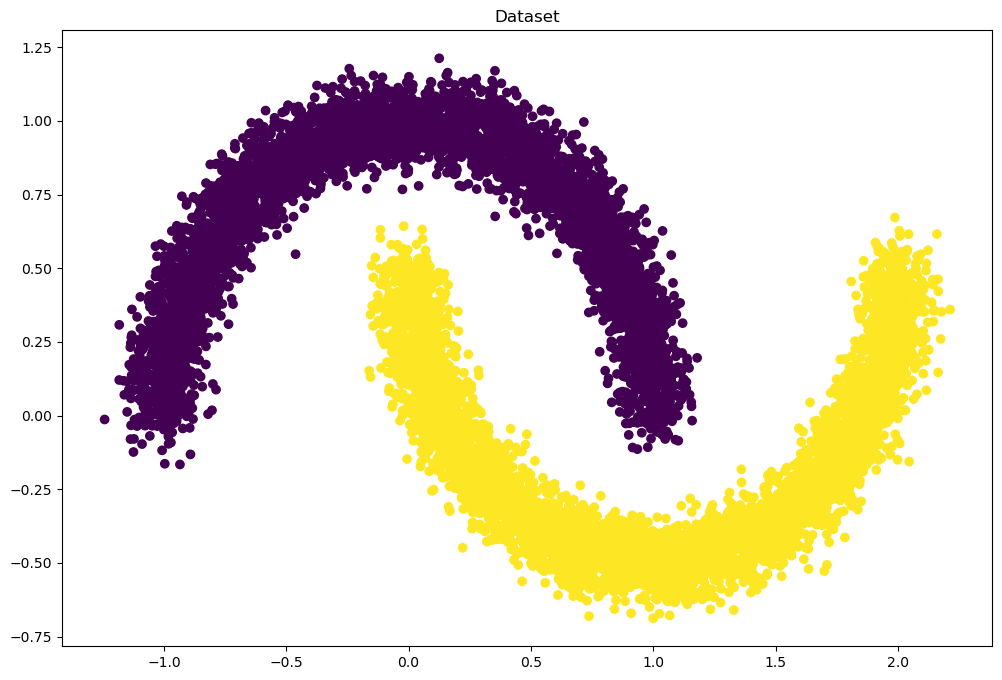

In [8]:
plt.figure(figsize=(12, 8))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Before we proceed we will split the dataset into **tain/validation**:

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

Convert to `torch.tensor`:

In [10]:
X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

And make `TensorDataset`'s from them:

In [14]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

Now, as we prepared our data, we can define our model with `nn.Sequential`:

In [15]:
model = nn.Sequential(
    LinearRegression(2, 1),
)

For loss function we will use [**`nn.BCEWithLogitsLoss`**](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) - it combines a Sigmoid layer and the BCELoss (binary cross-entropy loss) in one single class.

In [16]:
loss_function = nn.BCEWithLogitsLoss()

For optimizer we will use **Stochastic gradient descent** with learning rate = 0.05.

In [17]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

### Train loop

Here is some pseudo code to help you figure out what happens during training:

```python
for epoch in range(max_epochs):  # <----------- iterate over the dataset several times
    for x_batch, y_batch in dataset:  # <------ iterate over the dataset. Since we use SGD and not GD, we take batches of a given size
        optimizer.zero_grad()  # <------------- zero out the gradients of the model
        outp = model(x_batch)  # <------------- get "logits" from the model
        loss = loss_func(outp, y_batch)  # <--- calculate "loss" for logistic regression
        loss.backward()  # <------------------- calculate gradients
        optimizer.step()  # <------------------ do a gradient descent step
        if convergence:  # <------------------- in case of convergence, exit the cycle
            break
```

Our actual training function will look like this:

In [20]:
def train(model, epochs):
    losses = []
    max_epochs = epochs
    stop_it = False
    for epoch in range(max_epochs):
      
        for it, (X_batch, y_batch) in enumerate(train_dataloader):
            optimizer.zero_grad()
            outp = model(X_batch)
            loss = loss_function(outp.flatten(), y_batch)
            loss.backward()
            losses.append(loss.detach().flatten()[0])
            optimizer.step()
            probabilities = torch.sigmoid(outp)
            preds = (probabilities>0.5).type(torch.long)
    return model, losses

In [21]:
model, losses = train(model, 20)

### Loss

Next important step is to **plot loss function**:

In [22]:
def show_loss(losses):
    plt.figure(figsize=(12, 8))
    plt.plot(range(len(losses)), losses)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()

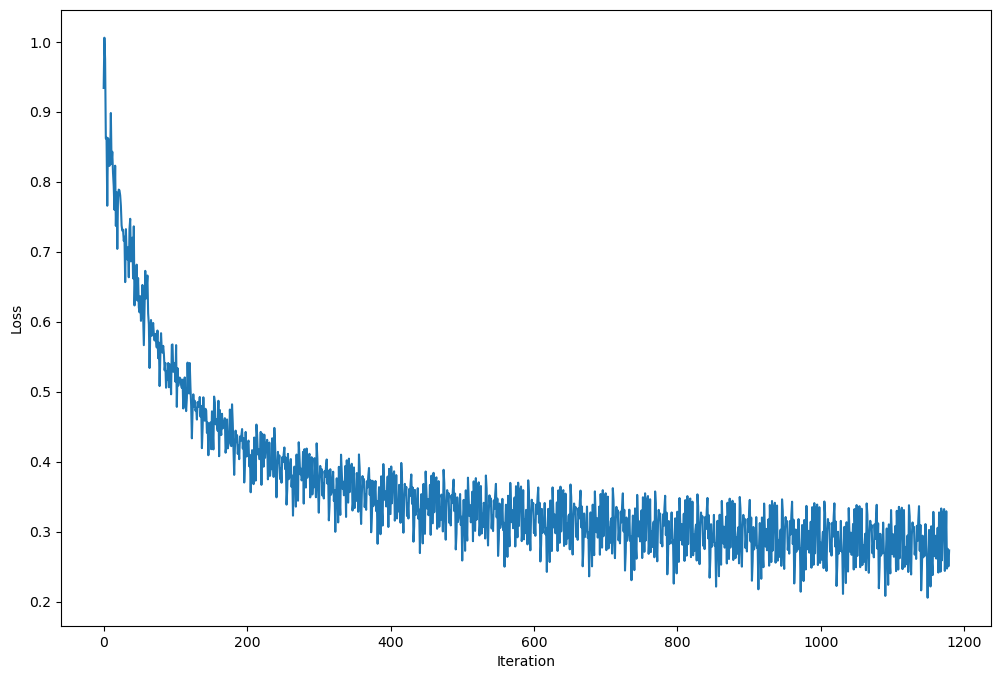

In [23]:
show_loss(losses)

### Visualizing

With neat playing with matplotlib we can visualize the separation between classes in two zones:

In [24]:
def show_separation(model, save=False, name_to_save=""):
    sns.set(style="white")

    xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    batch = torch.from_numpy(grid).type(torch.float32)
    with torch.no_grad():
        probs = torch.sigmoid(model(batch).reshape(xx.shape))
        probs = probs.numpy().reshape(xx.shape)

    f, ax = plt.subplots(figsize=(16, 10))
    ax.set_title("Decision boundary", fontsize=14)
    contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                          vmin=0, vmax=1)
    ax_c = f.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])

    ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
               cmap="RdBu", vmin=-.2, vmax=1.2,
               edgecolor="white", linewidth=1)

    ax.set(xlabel="$X_1$", ylabel="$X_2$")
    if save:
        plt.savefig(name_to_save)
    else:
        plt.show()

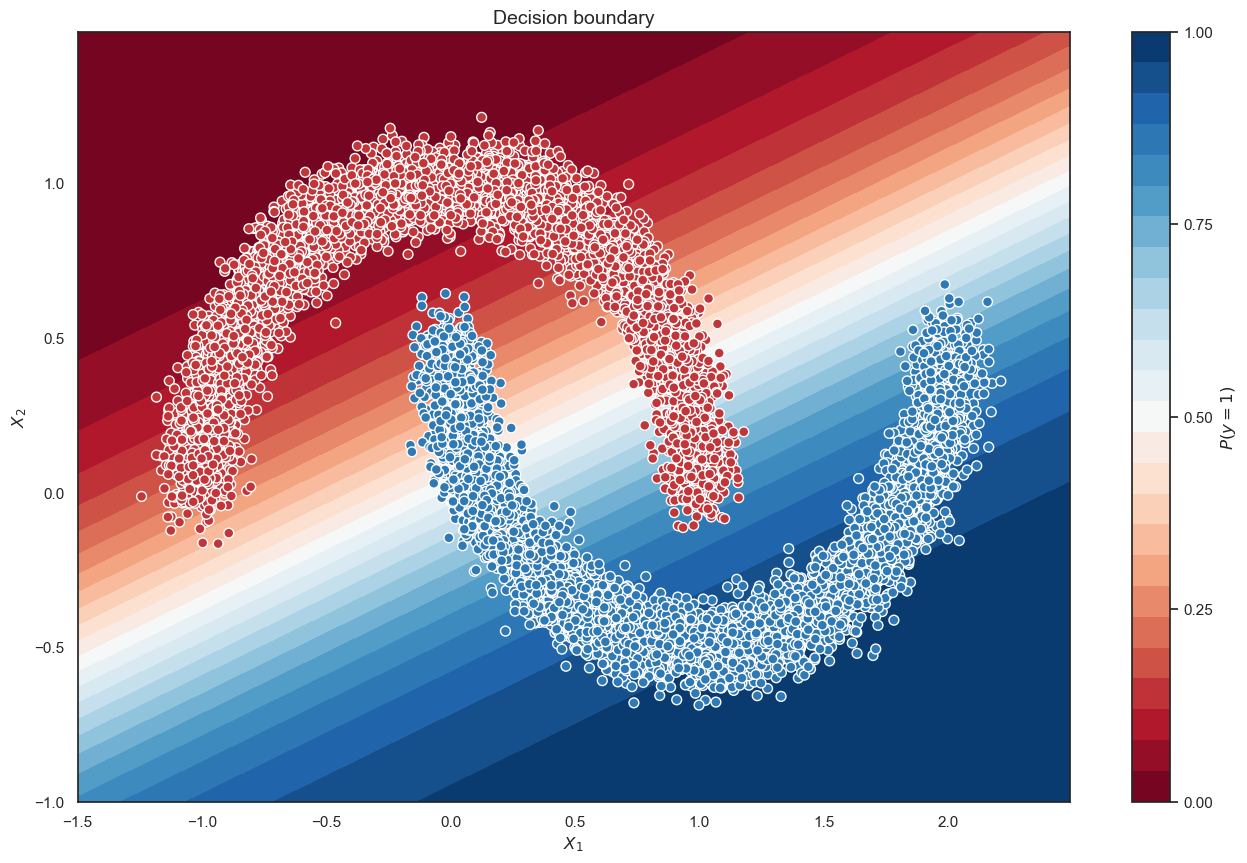

In [25]:
show_separation(model)

We got what we expected - **two "zones"**. Logistic regression module did the best it could. We can measure the accuracy of the model, but first we have to define `predict` function:

In [26]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    predictions = predictions
    return predictions.flatten()

**Accuracy**

In [27]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_val, predict(val_dataloader, model))
accuracy

0.878

### Simple Neural Network

For better result however we need something a little more complex. Again we will use `nn.Sequential` to make our model. This time it contains three `nn.Linear` layers and two activation functions. We will use the same loss function and optimizer:

In [28]:
model = nn.Sequential(
    nn.Linear(2, 30),
    nn.ReLU(),
    nn.Linear(30, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
)

loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

Train 30 epochs and show results:

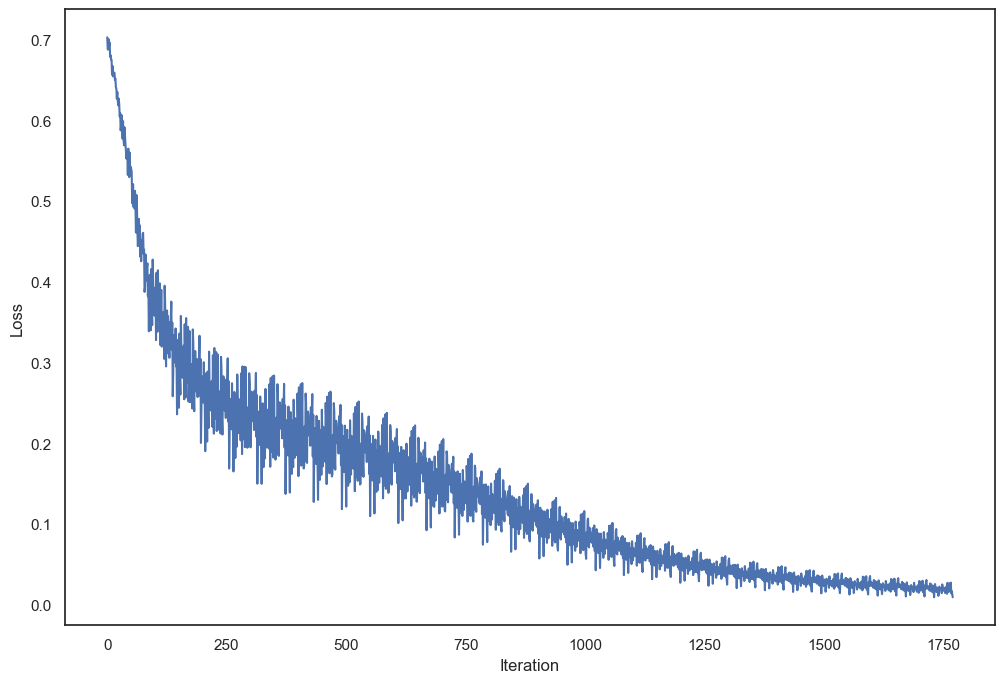

In [29]:
model, losses = train(model, 30)
show_loss(losses)

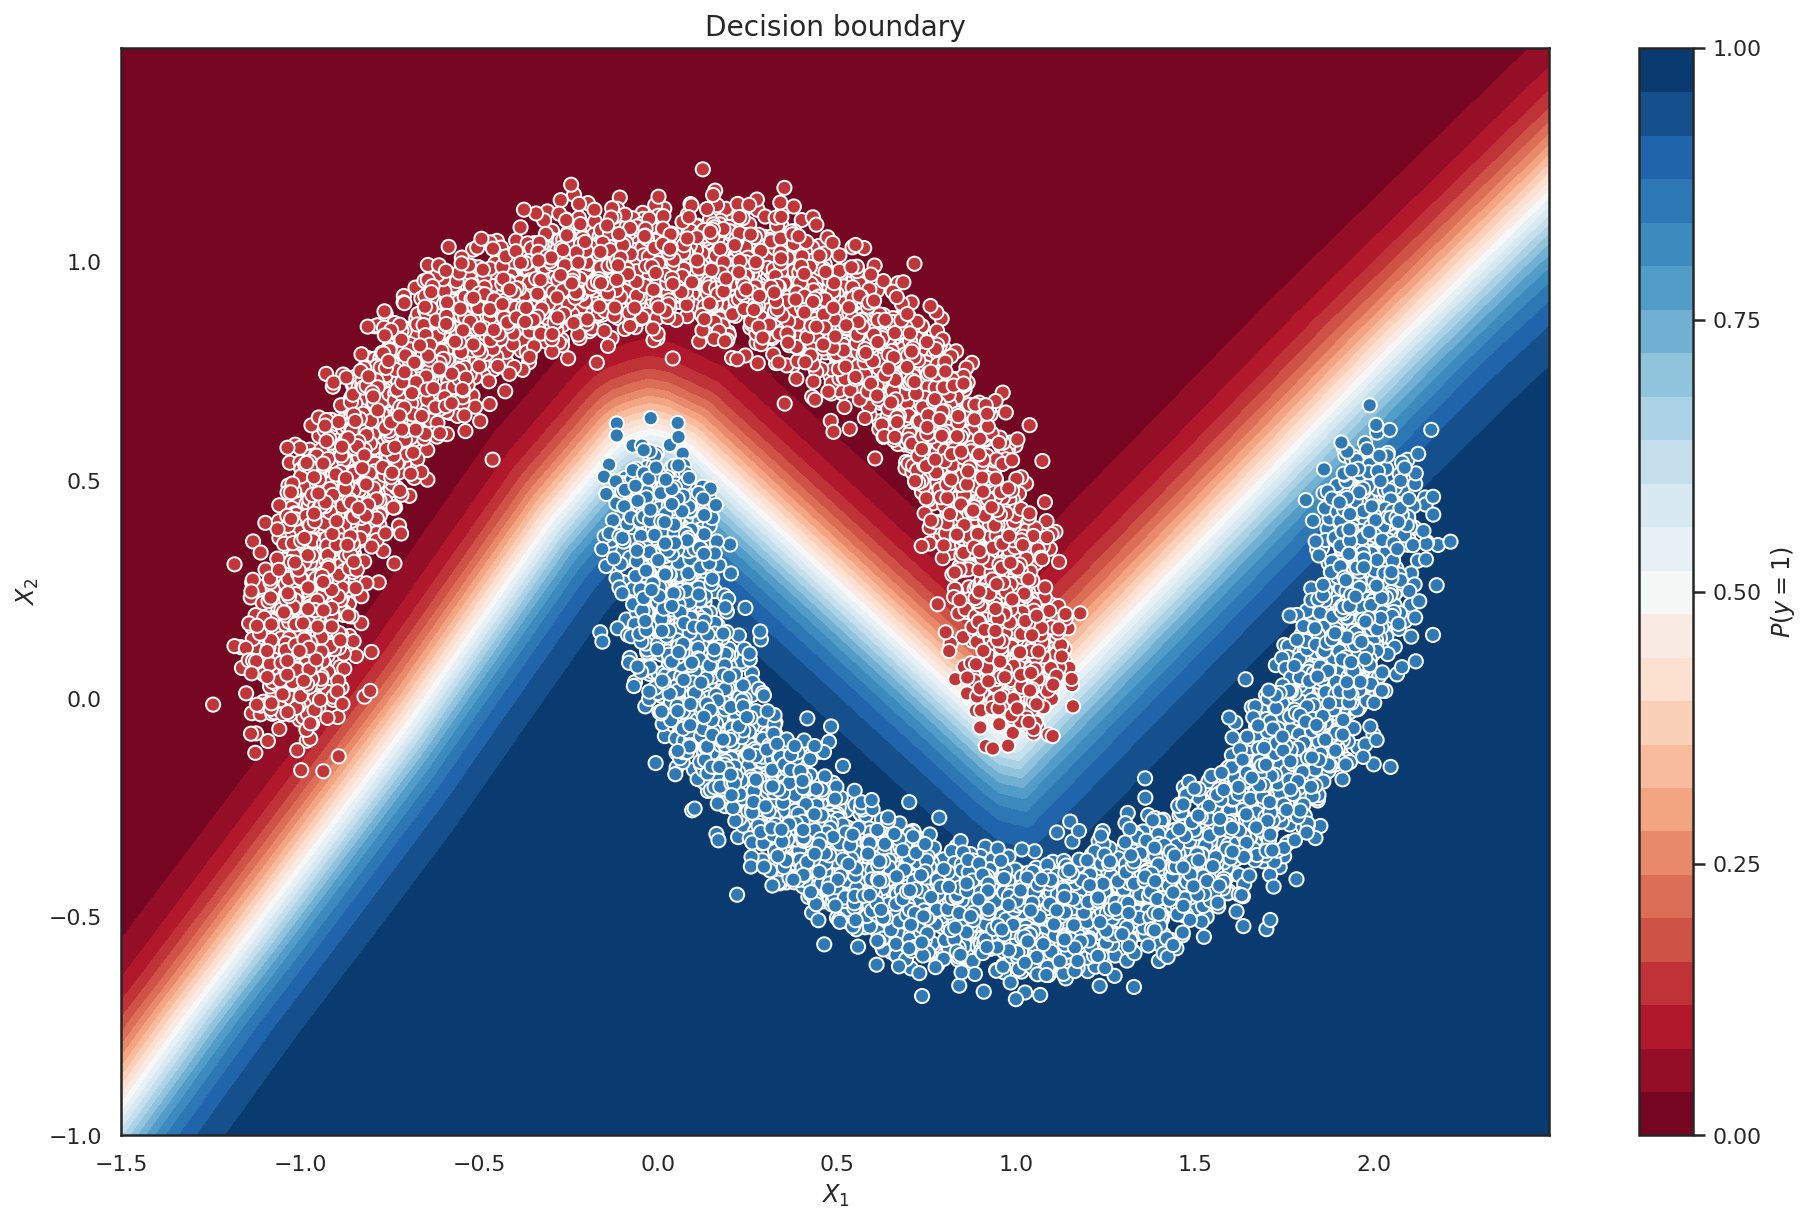

In [21]:
show_separation(model)

This is much better. We can see the **accuracy is almost 100%**

In [30]:
accuracy = accuracy_score(y_val, predict(val_dataloader, model))
accuracy

0.9988

### Make Circles Dataset

For demonstrative purposes we can do the same for **`make_circles`** dataset

In [31]:
X, y = make_circles(n_samples=10000, random_state=42, noise=0.02)

In [32]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [33]:
X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

In [34]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [35]:
model = nn.Sequential(
    nn.Linear(2, 30),
    nn.ReLU(),
    nn.Linear(30, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
)

loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

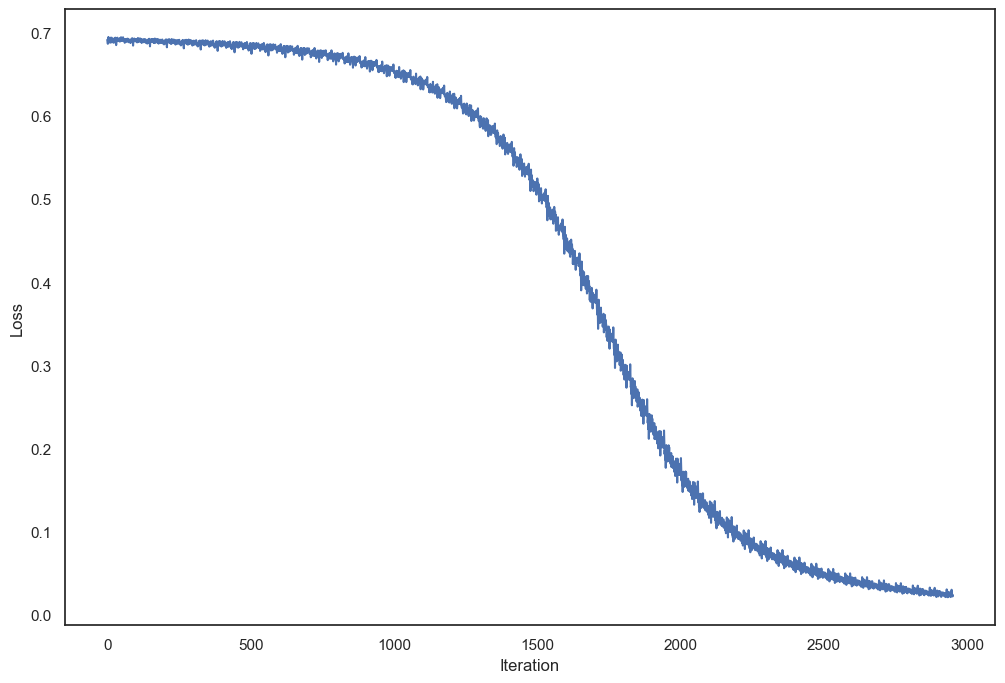

In [36]:
model, losses = train(model, 50)
show_loss(losses)

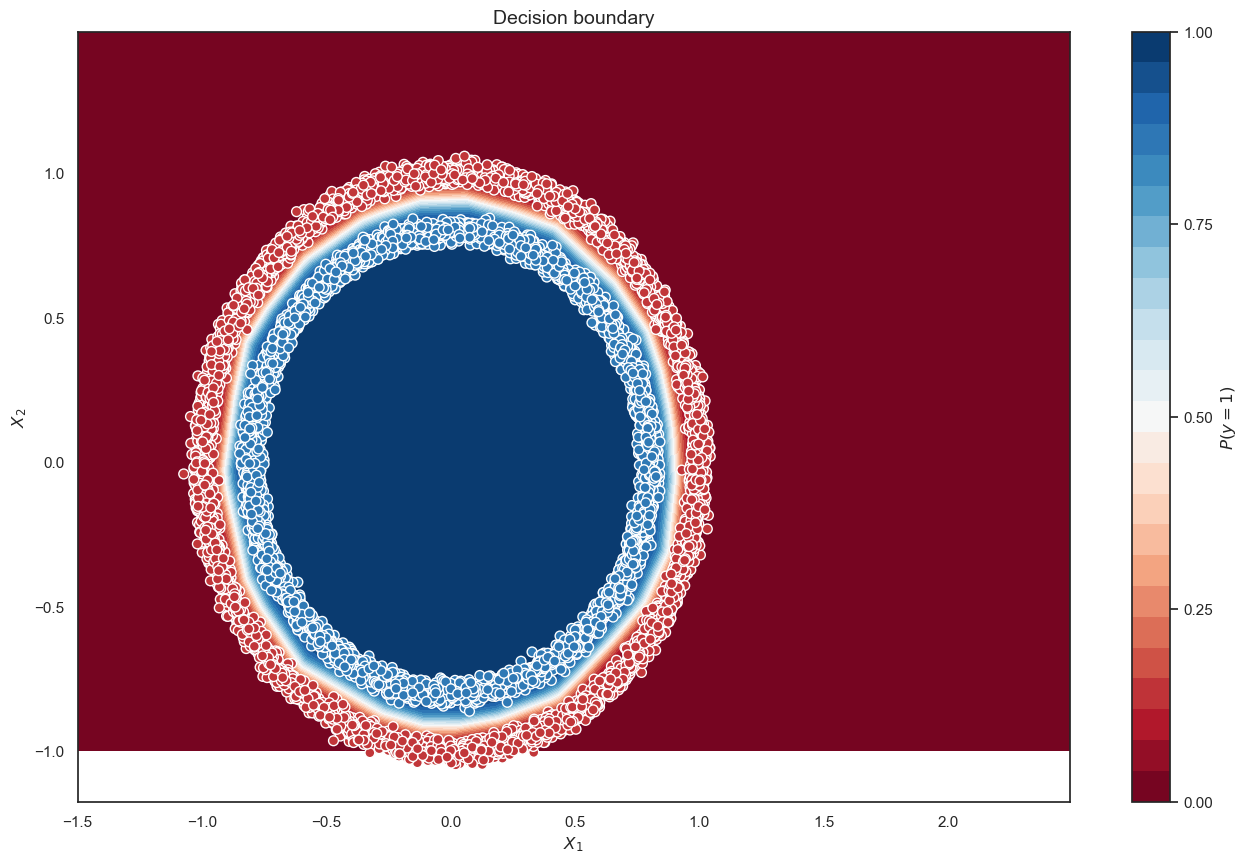

In [37]:
show_separation(model)

In [38]:
accuracy = accuracy_score(y_val, predict(val_dataloader, model))
accuracy

1.0